# First Year Project
## Project 1 - Road Collissions Analysis, ITU Copenhagen

This notebook contains all of the code developed for project 1, to explore the data set of Road Collisions from UK.gov with a focus on the city of Birmingham.

Nicola (niccl@itu.dk)<br>
Emma (ebis@itu.dk)<br>
Karlis (kabu@itu.dk)<br>
Kirstine (kirp@itu.dk)<br>
Danielle (ddeq@itu.dk)<br>

Created: 12-02-2021
<br>Last modified: 26-02-2021

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import csv

import json
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import folium
from folium.plugins import HeatMap, MarkerCluster


#%run -i ../scripts/functions.py

from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider,Checkbox
import ipywidgets as widgets

#in order for interactive to work run:
#pip install ipywidgets
#then run:
#jupyter nbextension enable --py widgetsnbextension
#(in the python terminal you run jupyter from)

## Functions

In [ ]:
def five_num_sum(data):
    """A function that takes the input data and calculates the
    five number summary.
    """
    quartiles = np.percentile(data, [25, 50, 75])
    data_min, data_max = min(data), max(data)
    
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)

In [ ]:
def BarPlot(title, field_catagories, data):
    """Function to make a bar plot of a categorical variable
    """
    
    field_name = title
    ax = barplot(data, field_name, field_categories)
    
    return plt.show()

In [ ]:
def barplot(data, field_name, field_categories):
    """Make a bar plot of a categorical variable, given as a field field_name in the
    structured array data. Field categories and their names are given in the dict field_categories.
    """

    categories, counts = np.unique(data[field_name], return_counts=True)

    fig = plt.figure(figsize=(4, 3))
    axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)
    axes.bar(range(len(categories)), counts, fc= "coral") # fc is the face color

    axes.set_xlabel("")
    axes.set_ylabel('Count')
    axes.set_title(field_name)
    fig.autofmt_xdate(rotation=45)

    axes.set_xticks(range(len(categories)))
    axes.set_xticklabels([field_categories[c] for c in categories]);

In [ ]:
def statistics_values(observed):
    """A function that takes the observed values from the crosstab and then 
    finds the expected output followed by the chi value, p-value, 
    degrees of freedom, and the Cramers V-value - NOTE: make sure input 
    is a numpy array"""
    
    chiVal, pVal, df, expected = chi2_contingency(observed)
    print("Chi Value: ", chiVal)
    print("P-value: ", pVal)
    print("Degrees of Freedom: ", df)
    
    V = np.sqrt( (chiVal/N) / (min(observed.shape)-1) )
    print("Cramer's V-value: ", V)

## Constants

In [ ]:
PATH = {}
PATH["data_raw"] = "../Data/raw/"
PATH["data_interim"] = "../Data/interim/"
PATH["data_processed"] = "../Data/processed/"
PATH["data_external"] = "../Data/external/"

FILENAME = {}
FILENAME["accidents"] = "Road Safety Data - Accidents 2019.csv"
FILENAME["casualties"] = "Road Safety Data - Casualties 2019.csv"
FILENAME["vehicles"] = "Road Safety Data- Vehicles 2019.csv" 

TABLENAMES = ["accidents", "casualties", "vehicles"]

# Task 0: Data filtering and cleaning
Out of the raw UK data, create a processed data set that is restricted to your city. You are going to use this processed data set for all the tasks below. This data set should contain only fields and records that are relevant to your analysis. Briefly describe your data set in a numerical summary (e.g. number/meaning of tables, fields and records, statistical key metrics).

The data were downloaded from here on Jan 4th: https://data.gov.uk/dataset/road-accidents-safety-data
That page was updated afterwards (Jan 8th), so local and online data may be inconsistent.

In [ ]:
dataraw = {}
dataraw["accidents"] = np.genfromtxt(PATH["data_raw"]+FILENAME["accidents"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["vehicles"] = np.genfromtxt(PATH["data_raw"]+FILENAME["vehicles"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')
dataraw["casualties"] = np.genfromtxt(PATH["data_raw"]+FILENAME["casualties"], delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [ ]:
# Get a dictionary of the variable names for each table
variable_names_raw = {}
for variable_name in TABLENAMES:
    variable_names_raw[variable_name] = list(dataraw[variable_name].dtype.names)

### Report the dimensions of the data (number of tables, rows, fields).

We have 3 tables: Accidents, Casualites, and Vehicles data tables.

#### Number of records in each table

In [ ]:
print(f"Number of records in accident table: {dataraw['accidents'].shape}")
print(f"Number of records in vehicles table: {dataraw['vehicles'].shape}")
print(f"Number of records in casualties table: {dataraw['casualties'].shape}")

#### Number of fields in each table

In [ ]:
print(f"Number of fields in the accident table: {len(dataraw['accidents'].dtype)}")
print(f"Number of fields in the vehicles table: {len(dataraw['vehicles'].dtype)}")
print(f"Number of fields in the casualties table: {len(dataraw['casualties'].dtype)}")

### Checking IDs

#### Does every AccidentID in the casualties and vehicles tables have their corresponding AccidentID in the accident table?

In [ ]:
raw_accident_AI=dataraw["accidents"]["Accident_Index"]
raw_vehicles_AI=dataraw["vehicles"]["Accident_Index"]
raw_casualties_AI=dataraw["casualties"]["Accident_Index"]

# Checking IDs in the Casualties table
mask_missing_c_AI = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (raw_accident_AI)))
print("Number of accident IDs in the casualties data:",len(raw_casualties_AI),
      "\nNumber of IDs in the casualties data tha also appear in the accidents data:",len(raw_casualties_AI[mask_missing_c_AI]))

# Checking IDs in the Vehicles table
mask_missing_v_AI = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (raw_accident_AI)))
print("")
print("Number of accident IDs in the vehicles data:",len(raw_vehicles_AI),
      "\nNumber of IDs in the cvehicles data tha also appear in the accidents data:", len(raw_vehicles_AI[mask_missing_v_AI]))

This shows that each casualty and vehicle on their respective sheets are also represented on the accident sheet, based on the raw data.

Yes, after cleaning both the casualties and vehicles sheets to only have records where their accident ID is in the cleaned Birmingham accident sheet.

#### Does every entry in the Accidents table reference the correct amount of entries in the vehicles and casualties tables?

In [ ]:
#dictionary of number of vehicles/casualties per ID
num_vehicles_for_id={}
num_casualties_for_id={}

#add each accident index as a key to the dictionaries
for i in dataraw["accidents"]:
    num_vehicles_for_id[i["Accident_Index"]]=0
    num_casualties_for_id[i["Accident_Index"]]=0

#count number of entries of each index in the vehicles/casualties tables
for i in dataraw["vehicles"]:
    num_vehicles_for_id[i["Accident_Index"]]+=1
for i in dataraw["casualties"]:
    num_casualties_for_id[i["Accident_Index"]]+=1

In [ ]:
#compare previous numbers to casualty and vehicle numbers listed on accidents table
for i in dataraw["accidents"]:
    if i["Number_of_Vehicles"]!=num_vehicles_for_id[i["Accident_Index"]]:
        print("There are mis-matching numbers of records i nvehicles data")
for i in dataraw["accidents"]:
    if i["Number_of_Casualties"]!=num_casualties_for_id[i["Accident_Index"]]:
        print("There are mis-matching numbers of records in casualties data")

Nothing prints, which would indicate a mismatch. 
Hence we can say that the accidents table references the correct amount of entries in the vehicles and casualties tables

### Masking for Birmingham

Birmingham is listed as code "300" under the "Local_Authority_District" field. First we narrowed down the accidents table to only show records that match this code in that field.

In [ ]:
# Create a dictionary to hold all of the clean data
data_bir = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask = np.where(dataraw["accidents"]["Local_Authority_District"] == 300)
data_bir["accidents"] = dataraw["accidents"][birmingham_mask]

Then we narrowed down the casualties and vehicles sheets to only have records that would be reflected in the accident sheet, thereby having only records of that pertain to Birmingham.

In [ ]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids = np.array(data_bir["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask = np.where(np.isin(dataraw["casualties"]["Accident_Index"], (accident_ids)))
data_bir["casualties"] = dataraw["casualties"][casualties_mask]

In [ ]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask = np.where(np.isin(dataraw["vehicles"]["Accident_Index"], (accident_ids)))
data_bir["vehicles"] = dataraw["vehicles"][vehicles_mask]

### Identify for each variable whether it is numerical or categorical.

#### Insight: Mixed variable types

Accidents have mixed data types, including strings, floats, and integers. Categorical variables are encoded as integers. The meaning of these categories can be looked up in: ../references/variable lookup.xls

In [ ]:
# Number of entries in each table after being filtered to Birmingham
print(f"Number of records in Birmingham accident table: {data_bir['accidents'].shape}")
print(f"Number of records in Birmingham casualties table: {data_bir['casualties'].shape}")
print(f"Number of records in Birmingham vehicles table: {data_bir['vehicles'].shape}")

We manually went through the variable lists to come up with which variables were categorical or numerical.

References<br>
what is categorical - http://www.stat.yale.edu/Courses/1997-98/101/catdat.htm <br>
the hell is LSOA - https://datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html#:~:text=A%20Lower%20Layer%20Super%20Output,Lower%20Layer%20Super%20Output%20Areas
decile -http://mast.roadsafetyanalysis.org/wiki/index.php?title=Driver_IMD_Decile#:~:text=An%20IMD%20decile%20is%20a,the%2010%25%20least%20deprived%20areas.


**Acidents** <br><br>
Accident_Index  - Categorical<br>
Location_Easting_OSGR  - Numerical<br>
Location_Northing_OSGR  - Numerical<br>
Longitude  - Numerical<br>
Latitude  - Numerical<br>
Police_Force  - Categorical<br>
Accident_Severity  - Categorical<br>
Number_of_Vehicles  - Numerical<br>
Number_of_Casualties  - Numerical<br>
Date  - Numerical/Categorical<br>
Day_of_Week  - Categorical<br>
Time  - Numerical(but can be categorical)<br>
Local_Authority_(District)  - Categorical<br>
Local_Authority_(Highway)  - Categorical<br>
1st_Road_Class  - Categorical<br>
1st_Road_Number  - Categorical<br>
Road_Type  - Categorical<br>
Speed_limit  - Categorical(we questioned this)<br>
Junction_Detail  - Categorical<br>
Junction_Control  - Categorical<br>
2nd_Road_Class  - Categorical<br>
2nd_Road_Number  - Categorical<br>
Pedestrian_Crossing-Human_Control  - Categorical<br>
Pedestrian_Crossing-Physical_Facilities  - Categorical<br>
Light_Conditions  - Categorical<br>
Weather_Conditions  - Categorical<br>
Road_Surface_Conditions  - Categorical<br>
Special_Conditions_at_Site  - Categorical<br>
Carriageway_Hazards  - Categorical<br>
Urban_or_Rural_Area  - Categorical<br>
Did_Police_Officer_Attend_Scene_of_Accident  - Categorical<br>
LSOA_of_Accident_Location  - Categorical<br>

**Vehicles**<br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Vehicle_Type  - Categorical<br>
Towing_and_Articulation  - Categorical<br>
Vehicle_Manoeuvre  - Categorical<br>
Vehicle_Location-Restricted_Lane  - Categorical<br>
Junction_Location  - Categorical<br>
Skidding_and_Overturning  - Categorical<br>
Hit_Object_in_Carriageway  - Categorical<br>
Vehicle_Leaving_Carriageway  - Categorical<br>
Hit_Object_off_Carriageway  - Categorical<br>
1st_Point_of_Impact  - Categorical<br>
Was_Vehicle_Left_Hand_Drive?  - Categorical<br>
Journey_Purpose_of_Driver  - Categorical<br>
Sex_of_Driver  - Categorical<br>
Age_of_Driver  - Numerical<br>
Age_Band_of_Driver  - Categorical<br>
Engine_Capacity_(CC)  - Numerical<br>
Propulsion_Code  - Categorical(probably)<br>
Age_of_Vehicle  - Numerical<br>
Driver_IMD_Decile  - Categorical<br>
Driver_Home_Area_Type  - Categorical<br>
Vehicle_IMD_Decile  - Categorical<br>

**Casualties** <br><br>
Accident_Index  - Categorical<br>
Vehicle_Reference  - Categorical<br>
Casualty_Reference  - Categorical<br>
Casualty_Class  - Categorical<br>
Sex_of_Casualty  - Categorical<br>
Age_of_Casualty  - Numerical<br>
Age_Band_of_Casualty  - Categorical<br>
Casualty_Severity  - Categorical<br>
Pedestrian_Location  - Categorical<br>
Pedestrian_Movement  - Categorical<br>
Car_Passenger  - Categorical<br>
Bus_or_Coach_Passenger  - Categorical<br>
Pedestrian_Road_Maintenance_Worker  - Categorical<br>
Casualty_Type  - Categorical<br>
Casualty_Home_Area_Type  - Categorical<br>
Casualty_IMD_Decile  - Categorical<br>

## Dealing with missing data

#### First we will go through missing data from the unfiltered data for all of UK

In [ ]:
dataraw_masked = {}
for variable_name in TABLENAMES:
    dataraw_masked[variable_name] = np.genfromtxt(PATH["data_raw"] + FILENAME[variable_name], delimiter = ',', 
                                                  dtype = None, names = True, encoding='utf-8-sig', usemask = True)

In [ ]:
# Rows where data is missing
row_incomplete = np.where(dataraw_masked["accidents"].mask)[0]

In [ ]:
missingpositions = {}
missingvalues = 0
missingconfigurations = set()
for rowpos in row_incomplete:
    missingpositions_thisrow = list(np.where(list(dataraw_masked["accidents"].mask[rowpos]))[0])
    missingpositions[rowpos] = missingpositions_thisrow
    missingvalues += len(missingpositions_thisrow)
    missingconfigurations.add(tuple(missingpositions_thisrow))
    
missingfieldnames = [np.array(variable_names_raw["accidents"])[c] for c in [list(b) for b in missingconfigurations]]

In [ ]:
print("Incomplete rows: " + str(np.count_nonzero(dataraw_masked["accidents"].mask)))
print(f"Percentage of rows with missing values: {round(5776/117536, 2)}%")
print("Missing values: " + str(missingvalues))

print("\nMissing field configurations: " + str(missingconfigurations))
for i in missingfieldnames:
    print(i)

#### Then, we will repeat the same steps with the tables that only contain records of Birmingham.

In [ ]:
# Create a dictionary for the clean, masked data
data_bir_masked = {}

# creating the mask to show the data for Birmingham on the accidents sheet
birmingham_mask2 = np.where(dataraw_masked["accidents"]["Local_Authority_District"] == 300)
data_bir_masked["accidents"] = dataraw_masked["accidents"][birmingham_mask2]

In [ ]:
# Create an array of the accident IDs related to Birmingham (use this to filter the other tables)
accident_ids2 = np.array(data_bir_masked["accidents"]["Accident_Index"])

# Create a mask to filter casualties table based on the accident ids
casualties_mask2 = np.where(np.isin(dataraw_masked["casualties"]["Accident_Index"], (accident_ids2)))
data_bir_masked["casualties"] = dataraw_masked["casualties"][casualties_mask2]

In [ ]:
# Create a mask to filter vehicles table based on the accident ids
vehicles_mask2 = np.where(np.isin(dataraw_masked["vehicles"]["Accident_Index"], (accident_ids2)))
data_bir_masked["vehicles"] = dataraw_masked["vehicles"][vehicles_mask2]

In [ ]:
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['accidents'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['casualties'].mask)}")
print(f"Number of rows with missing values: {np.count_nonzero(data_bir_masked['vehicles'].mask)}")

It seems there are no records in our Birmingham data set that have missing values. By missing values, we mean that there is an empty field. It is still possible that there is a value "-1" entered into a field, which means "missing" or "unknown" depending on the variable.

### Making sure the values make sense (ex. Age cannot = -1)
What we need to check for:
- making sure that values for missing values can't be interpreted as real values
<br>especially for numerical values as missing values stored as 999999 for example may affect calculations
- counts of missing values in each column
we dont think doing this would be usefull. 
But if needed in futrue the njust make a mask of the data where the values are "missing values" and find length

#### Numerical Variables 
The missing values represented as:<br>
(Looked up in Excel)
<br>

##### Note: all the following points are in regard to ALL the data and not just the Birmingham Data

**Accidents** <br><br>
Location_Easting_OSGR: Null (No values missing)<br>
Location_Northing_OSGR: Null <br>
Longitude: Null<br>
Latitude: Null<br>
Number_of_Vehicles: values from 1-17 none missing  <br>
Number_of_Casualties: values from 1-52 none missing<br>
<br>
**Vehicles**<br><br>
Age_of_Driver: 1-102 missing is -1 (we should change this or at least be aware of this if we want to do any numerical analysis) the one year old was driving an unidentified vehicle and was not hurt<br>
Engine_Capacity_(CC): 1-29980 missing values -1  (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
Age_of_Vehicle: 1-94 missing vaules are -1 (we should change this or at least be aware of this if we want to do any numerical analysis)<br>
<br>
**Casualties**<br><br>
Age_of_Casualty:  -1 (we should change this or at least be aware of this if we want to do any numerical analysis)
<br>

In [ ]:
# Cleaning the Age_of_Driver to account for negative numbers
age_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Driver"] > 0)
clean_AOD_accidents = data_bir["vehicles"][age_cleaning_mask]

In [ ]:
# Cleaning the Engine_Capacity_CC for negative numbers
EC_cleaning_mask = np.where(data_bir["vehicles"]["Engine_Capacity_CC"] > 0)
clean_EC_vehicles = data_bir["vehicles"][EC_cleaning_mask]

In [ ]:
# Cleaning the Age_of_Vehicle for negative numbers
AOV_cleaning_mask = np.where(data_bir["vehicles"]["Age_of_Vehicle"] > 0)
clean_AOV_vehicles = data_bir["vehicles"][AOV_cleaning_mask]

In [ ]:
# Cleaning the Age_of_Casualty for negative numbers
AOC_cleaning_mask = np.where(data_bir["casualties"]["Age_of_Casualty"] > 0)
clean_AOC_casualties = data_bir["casualties"][AOC_cleaning_mask]

We may not necessarily use these variables. It was an exercise to make sure we could clean the data to remove entries (such as -1) that do not make sense. We can do this same technique where applicable when plotting the data.

### Five number summarys for all numerical variables, Box Plots, Frequency Histograms

#### Number of vehicles

In [ ]:
number_of_vehicles = data_bir["accidents"]["Number_of_Vehicles"]
five_num_sum(number_of_vehicles)

In [ ]:
#Histogram and Boxplot for Number_of_Vehicles 
fig = plt.figure(figsize=(6,6));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_vehicles, 6, density= True, color='#0D8CFF');
ax2.boxplot(number_of_vehicles, showfliers= True, vert=False, whis = [0,100]);

ax1.set_xlabel('Number of vehicles');
ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Number of vehicles');
fig.suptitle('Number of Vehicles involved in an accident');

There were at most 7 vehicles involved in an accident in Birmingham. The median number of cars is 2 per accident.

#### Number of Casualties

In [ ]:
number_of_casualties = sorted(data_bir["accidents"]["Number_of_Casualties"])
five_num_sum(number_of_casualties)

In [ ]:
#Histogram and Boxplot for number_of_casualties 
fig = plt.figure(figsize=(6,6));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(number_of_casualties, 7, color='#0D8CFF');
ax2.boxplot(number_of_casualties, showfliers= True, vert=False, whis = [0, 100]);

ax1.set_xlabel('Number of Casualties per accident');
ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Number of Casualties per accident');
fig.suptitle('Casualties');     

There have been at most 8 casualties involved in an accident in Birmingham. However, the min, Q1, median, and Q2 values are all 1, showing that there are usually only 1 casualty involved.

#### Age of Driver

In [ ]:
age_of_driver = sorted(clean_AOD_accidents["Age_of_Driver"])
five_num_sum(age_of_driver)

In [ ]:
#Histogram and Boxplot for age_of_driver
fig = plt.figure(figsize=(6,6));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_driver, 45, color='#0D8CFF');
ax2.boxplot(age_of_driver, showfliers= False, vert=False, whis = [0,100]);

ax1.set_xlabel('Age');
ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Age');
fig.suptitle('Age of drivers');

Age of drivers involved in accidents in Birmingham range from 3 to 93. The bulk seem to be between mid-20's to mid-40's, with the median being 36.

#### Engine Capacity

In [ ]:
#using the data from clean_EC_vehicles
engine_capacity = sorted(clean_EC_vehicles["Engine_Capacity_CC"])
quartiles_EC = np.percentile(engine_capacity, [25, 50, 75])

five_num_sum(engine_capacity)

In [ ]:
#Histogram and Boxplot for engine_capacity
fig = plt.figure(figsize=(6,6));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(engine_capacity, 45, color='#0D8CFF');
ax2.boxplot(engine_capacity, showfliers= False, vert=False, whis= [0,100]);

ax1.set_xlabel('Engine capacity');
ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Engine capacity');
fig.suptitle('Engine capacity of Vehicles in an Accident');

Engine capacity of vehicles involved in accidents range from 49 to 12902. The data reference sheet does not specify whether it is in cc or horsepower, but cc seems like it could apply here, with a 49cc engine belonging to a scooter, and a 12902 being a high-end sports car or a train. The Q1, median, and Q2 figures are 1360, 1598, and 1988, which all fall under typical engine sizes in cc.

#### Age of Vehicle

In [ ]:
#using the data from clean_AOV_vehicles
age_of_vehicle = sorted(clean_AOV_vehicles["Age_of_Vehicle"])
five_num_sum(age_of_vehicle)

In [ ]:
#Histogram and Boxplot for age_of_vehicle
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_vehicle, 35, color='#0D8CFF');
ax2.boxplot(age_of_vehicle, showfliers= False, vert=False, whis= [0,100]);

ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Age of vehicle');
fig.suptitle('Age of vehicle involved in an Accident');

Minimum vehicle age is 1, and maximum is 36 for vehicles involved in accidents in Birmingham, with majority of those falling between 4 and 12 years old.

#### Age of Casualty

In [ ]:
# using the data from clean_AOC_casualties
age_of_casualty = sorted(clean_AOC_casualties["Age_of_Casualty"])
five_num_sum(age_of_casualty)

In [ ]:
#Histogram and Boxplot for age_of_casualty
fig = plt.figure(figsize=(5,5));
fig, (ax1, ax2) = plt.subplots(2, 1);
ax1.hist(age_of_casualty, 45, color='#0D8CFF');
ax2.boxplot(age_of_casualty, showfliers= False, vert=False, whis=[0,100]);

ax1.set_ylabel('Frequency');

ax2.set_yticks([])
ax2.set_xlabel('Age');
fig.suptitle('Age of Casualties');

Casualties range from 1 to 94 years old, with the majority being between ages 22 and 46. The data seems right tailed, indicating that there are less causualites in the higher age ranges than there are in the lower age ranges.

# Task 1: Single Variable Analysis
Report the frequency of road collisions in your city for 1) different age groups, 2) in different times
(during the day, the week, or year), 3) and for differences in one other condition.

##### We are also comparing for the whole of the UK to Birmingham

#### Vehicle type counts for Birmingham and the UK

In [ ]:
field_categories = {1: "Pedal cycle", 2: "Motorcycle 50cc-", 3: "Motorcycle 125cc-", 4: "Motorcycle (125cc-500cc)", 
                    5: "Motorcycle 500cc+", 8: "Taxi", 9: "Car", 10 : "Minibus (8-16 passenger)", 
                    11: "Bus or coach (17+ passenger)", 16: "Ridden horse", 17: "Agricultural vehicle", 18: "Tram", 
                    19: "Van / Goods 3.5t-", 20: "Goods (3.5t-7.5t)", 21: "Goods 7.5t+", 22: "Mobility scooter", 
                    23: "Electric motorcycle", 90: "Other vehicle", 97: "Motorcycle - unknown cc", 
                    98: "Goods vehicle - unknown weight", -1: "Data missing"}

In [ ]:
categories, counts = np.unique(data_bir["vehicles"]["Vehicle_Type"], return_counts=True)
cat2, count2 = np.unique(dataraw["vehicles"]["Vehicle_Type"], return_counts=True)

fig = plt.figure(figsize= (10,10));
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5));
fig.autofmt_xdate(rotation=45)

ax1.bar(range(len(categories)),counts, fc = "#11CEFF")
ax2.bar(range(len(cat2)),count2, fc = "#11CEFF")

ax1.set_xticks(range(len(categories)))
ax1.set_title("Type of Vehicles in Birmingham")
ax1.set_xticklabels([field_categories[c] for c in categories])
ax1.set_ylabel("Counts")

ax2.set_xticks(range(len(cat2)))
ax2.set_title("Type of Vehicles in the whole UK")
ax2.set_xticklabels([field_categories[c] for c in cat2])

plt.show()

We had thought that Birmingham would have more bus accidents due to its central location between other parts of the UK, but we see that the majority are quite largely cars.

In [ ]:
field_categories = {1: "Pedal cycle", 2: "Motorcycle 50cc-", 3: "Motorcycle 125cc-", 4: "Motorcycle (125cc-500cc)", 
                    5: "Motorcycle 500cc+", 8: "Taxi", 10 : "Minibus (8-16 passenger)", 11: "Bus or coach (17+ passenger)", 
                    16: "Ridden horse", 17: "Agricultural vehicle", 18: "Tram", 19: "Van / Goods 3.5t-", 20: "Goods (3.5t-7.5t)",
                    21: "Goods 7.5t+", 22: "Mobility scooter", 23: "Electric motorcycle", 90: "Other vehicle", 
                    97: "Motorcycle - unknown cc", 98: "Goods vehicle - unknown weight", -1: "Data missing"}

mask = (data_bir["vehicles"]["Vehicle_Type"] != 9)
bir_veh_no_car = data_bir["vehicles"][mask]

mask = (dataraw["vehicles"]["Vehicle_Type"] != 9)
uk_veh_no_car = dataraw["vehicles"][mask]

categories, counts = np.unique(bir_veh_no_car["Vehicle_Type"], return_counts=True)
cat2, count2 = np.unique(uk_veh_no_car["Vehicle_Type"], return_counts=True)

fig = plt.figure(figsize= (10,10));
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5));
fig.autofmt_xdate(rotation=45)

ax1.bar(range(len(categories)),counts, fc = "#11CEFF")
ax2.bar(range(len(cat2)),count2, fc = "#11CEFF")

ax1.set_xticks(range(len(categories)))
ax1.set_title("Type of Vehicles in Birmingham (excluding cars)")
ax1.set_xticklabels([field_categories[c] for c in categories])
ax1.set_ylabel("Counts")

ax2.set_xticks(range(len(cat2)))
ax2.set_title("Type of Vehicles in the whole UK (excluing cars)")
ax2.set_xticklabels([field_categories[c] for c in cat2])

plt.show()

After removing car data and plotting the vehicles, it is easier to narrow in on which vehicles are involved in accidents outside of cars. We did not delve further into this, since cars are still involved in a large majority of accidents. But it would be interesting, given more time, if we could see how to make the roads safer by targeting specific vehicle types.

#### Comparing Sex of Driver for Birmingham and the UK

In [ ]:
# Remove unknown or out of range from Birminham data
gender_mask = (data_bir["vehicles"]["Sex_of_Driver"] == 1 ) | ( data_bir["vehicles"]["Sex_of_Driver"] == 2)
bir_driver_gender_masked = data_bir["vehicles"][gender_mask]

# Remove unknown or out of range from UK data
mask1 = (dataraw["vehicles"]["Sex_of_Driver"] == 1 ) | ( dataraw["vehicles"]["Sex_of_Driver"] == 2)
uk_driver_masked = dataraw["vehicles"][mask1]

In [ ]:
cat_sex_driver, count_sex_driver = np.unique(bir_driver_gender_masked["Sex_of_Driver"], return_counts=True)
cat_sex_driver_uk, count_sex_driver_uk = np.unique(uk_driver_masked["Sex_of_Driver"], return_counts=True)

fig = plt.figure(figsize= (5,5));
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5));
fig.autofmt_xdate(rotation=45)

ax1.bar(range(len(cat_sex_driver)),count_sex_driver, color = ["#236EF5","#3ADEA1"])
ax2.bar(range(len(cat_sex_driver_uk)),count_sex_driver_uk, color = ["#236EF5","#3ADEA1"])

ax1.set_xticks(range(len(cat_sex_driver)))
ax1.set_title("Sex of Drivers in Birmingham")
ax1.set_xticklabels(["Male", "Female"])

ax2.set_xticks(range(len(cat_sex_driver_uk)))
ax2.set_title("Sex of Drivers in the whole UK")
ax2.set_xticklabels(["Male", "Female"])

plt.show()

In [ ]:
labels = "Male", " Female"
percentages_bir = [(count_sex_driver[0]/sum(count_sex_driver))*100, (count_sex_driver[1]/sum(count_sex_driver))*100]
percentages_UK = [(count_sex_driver_uk[0]/sum(count_sex_driver_uk))*100, (count_sex_driver_uk[1]/sum(count_sex_driver_uk))*100]

fig = plt.figure(figsize=(5,5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.pie(percentages_bir, labels=labels, explode = [0.1,0],shadow = True, colors = ["#236EF5","#3ADEA1"],startangle=90, autopct='%1.2f%%')
ax1.set_title("Sex of Drivers in Birmingham")

ax2.pie(percentages_UK, labels=labels, explode = [0.1,0],shadow = True, colors = ["#236EF5","#3ADEA1"], startangle=90, autopct='%1.2f%%')
ax2.set_title("Sex of Drivers in the UK")

plt.show()

In [ ]:
print(f"Percentage of male drivers in Birmingham {round((counts[0]/sum(counts))*100,2)}%")
print(f"Percentage of female drivers in Birmingham {round((counts[1]/sum(counts))*100,2)}%")
print("")
print(f"Percentage of male drivers in the whole UK {round((count2[0]/sum(count2))*100,2)}%")
print(f"Percentage of female drivers in the whole UK {round((count2[1]/sum(count2))*100,2)}%")

Comparing sex of drivers in accidents in Birmingham to the rest of the UK shows that the percentages are quite similar. The majority of accidents have male drivers. It would be interesting to compare with the demographics of drivers in the UK in total, including those that do not have accidents. Because then we could compare if males are more likely to have an accident vs famales. However, we do not know if it is simply that 72% of all drivers are male, which would make it statistically more likely for male drivers to have an accident if if the likelyhood is 50/50. 

#### Comparing road types in Birmingham and the UK

In [ ]:
road_types = {1: "Roundabout", 2: "One way street", 3: "Dual carriageway", 6: "Single carriageway", 7: "Slip road", 
                    9 : "Unknown", 12: "One way street/Slip road", -1: "Data missing or out of range"}

In [ ]:
cat_road, count_road = np.unique(data_bir["accidents"]["Road_Type"], return_counts=True)
cat_road_uk, count_road_uk = np.unique(dataraw["accidents"]["Road_Type"], return_counts=True)

fig = plt.figure(figsize= (10,10));
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5));
fig.autofmt_xdate(rotation=45)

ax1.bar(range(len(cat_road)),count_road, fc = "#11CEFF")
ax2.bar(range(len(cat_road_uk)),count_road_uk, fc = "#11CEFF")

ax1.set_xticks(range(len(cat_road)))
ax1.set_title("Road Types in Birmingham")
ax1.set_xticklabels([road_types[c] for c in cat_road])
ax1.set_ylabel("Counts")

ax2.set_xticks(range(len(cat_road_uk)))
ax2.set_title("Road Types in the whole UK")
ax2.set_xticklabels([road_types[c] for c in cat_road_uk])

plt.show()

The data in Birmingham seems to reflect a similar pattern to that expressed in the whole UK. Overall, the majority of accidents occur on single carriageways. The next highest amount of accidents occur on dual carriageways, but it appears to be 1/3 of the accidents on single carriageways, which indicates that singlecarriageways are more dangerous. It would be interesting to explore the severity of accidents on these road types.

#### Comparing Accident Times of Day

In [ ]:
# The following is mostly used so that we understand what each time category is referring to
time_categories = {"00": "0:00-01:00", "01": "01:00-02:00", "02": "02:00-03:00", "03": "03:00-04:00", "04": "04:00-05:00", 
                   "05": "05:00-06:00", "06": "06:00-07:00", "07": "07:00-08:00", "08": "08:00-09:00", "09": "09:00-10:00", 
                   "10": "10:00-11:00", "11": "11:00-12:00", "12": "12:00-13:00", "13": "13:00-14:00", "14": "14:00-15:00", 
                   "15": "15:00-16:00", "16": "16:00-17:00", "17": "17:00-18:00", "18": "18:00-19:00", "19": "19:00-20:00",
                   "20": "20:00-21:00", "21": "21:00-22:00","22": "22:00-23:00", "23": "23:00-24:00"}

In [ ]:
# Make a count of the accidents at each time in Birmingham
times_dic_count = {}
for time_category in time_categories:
    times_dic_count[time_category] = 0
for i in range(len(data_bir["accidents"]["Time"])):
    times_dic_count[data_bir["accidents"]["Time"][i][:2]] += 1
    
# Make a count of the accidents at each time in the UK
times_dic_count_uk = {}
for time_category in time_categories:
    times_dic_count_uk[time_category] = 0
times_dic_count_uk[''] = 0
for i in range(len(dataraw["accidents"]["Time"])):
    times_dic_count_uk[dataraw["accidents"]["Time"][i][:2]] += 1
times_dic_count_uk.pop('')

63 accidents were removed from the UK data for this graph, because the time field was left blank. We felt like it was safe to remove this data, since it is such a small amount of the total and should not affect the output noticeably. Had there been a larger percentage with missing time data, we would not have plotted this, as it would not be relevent.

In [ ]:
fig = plt.figure(figsize=(20,20));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
fig.autofmt_xdate(rotation=45)

ax1.bar(times_dic_count.keys(), times_dic_count.values(), fc="#11CEFF")
ax2.bar(times_dic_count_uk.keys(), times_dic_count_uk.values(), fc="#11CEFF")

ax1.set_title("Accident Times in Birmingham")
ax1.set_xlabel("Time of Day")
ax1.set_ylabel("Count")

ax2.set_title("Accident Times in the UK")
ax2.set_xlabel("Time of Day")
ax2.set_ylabel("Count")

plt.show()

In Birmingham, between 10:00 til 14:00 there are less accidents than the rest of the UK, but between 18:00-20:00 there are more.

#### Frequency of Age of Casualties

In [ ]:
cat_cas_age, count_cas_age = np.unique(data_bir["casualties"]["Age_Band_of_Casualty"], return_counts=True)
#remove -1 from the data to plot
count_cas_age, cat_cas_age = count_cas_age[1:], cat_cas_age[1:]

cat_cas_age_uk, count_cas_age_uk = np.unique(dataraw["casualties"]["Age_Band_of_Casualty"], return_counts=True)
cat_cas_age_uk, count_cas_age_uk = cat_cas_age_uk[1:], count_cas_age_uk[1:]

fig = plt.figure(figsize=(7,4));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
catogories_age = ["0 - 5","6 - 10","11 - 15","16 - 20","21 - 25","26 - 35","36 - 45","46 - 55","56 - 65","66 - 75","75+"]

ax1.bar(catogories_age, count_cas_age, fc="#11CEFF")
ax2.bar(catogories_age, count_cas_age_uk, fc="#11CEFF")
fig.autofmt_xdate(rotation=45)

ax1.set_xlabel("Age bands")
ax1.set_ylabel("Frequency")
ax1.set_title("Age band of Casualties in Birmingham")
ax2.set_title("Age band of Casualties in the UK")
ax2.set_xlabel("Age bands")
plt.show()

This graph shows that those between 26-35 are more likely to be casualities in an accident. It would be interesting to know the age of drivers in general, to compare if the ages of casualties follow along with ages of drivers in general, or if there is a statistical significance. 

#### Frequencies of Age of Driver

In [ ]:
cat_age_driver, count_age_driver = np.unique(data_bir["vehicles"]["Age_Band_of_Driver"], return_counts=True)
# remove -1 from the data to plot
count_age_driver, cat_age_driver = count_age_driver[1:], cat_age_driver[1:]

cat_age_driver_uk, count_age_driver_uk = np.unique(dataraw["vehicles"]["Age_Band_of_Driver"], return_counts=True)
cat_age_driver_uk, count_age_driver_uk = cat_age_driver_uk[1:], count_age_driver_uk[1:]

fig = plt.figure(figsize=(7,4));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
catogories_age = ["0 - 5","6 - 10","11 - 15","16 - 20","21 - 25","26 - 35","36 - 45","46 - 55","56 - 65","66 - 75","75+"]

ax1.bar(catogories_age, count_age_driver_uk, fc="#11CEFF")
ax2.bar(catogories_age, count_age_driver_uk, fc="#11CEFF")

fig.autofmt_xdate(rotation=45)

ax1.set_xlabel("Age Bands")
ax1.set_ylabel("Frequency")
ax1.set_title("Age band of drivers in Birmingham")

ax2.set_xlabel("Age Bands")
ax2.set_title("Age band of drivers in the UK")
plt.show()

This graph shows that the highest age band in an accident is those between 26-35. It seems to follow the pattern of those that are casualties. Again, it leads us to wonder if it just so happens that there are more drivers on the road between 25-36.

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(17,17))

# time of day
axes[0,0].bar(times_dic_count.keys(), times_dic_count.values(), fc="#11CEFF")
axes[0,1].bar(times_dic_count_uk.keys(), times_dic_count_uk.values(), fc="#11CEFF")

# road type
axes[1,0].bar(range(len(cat_road)),count_road, fc = "#11CEFF")
axes[1,1].bar(range(len(cat_road_uk)),count_road_uk, fc = "#11CEFF")

# sex of driver
axes[2,0].pie(percentages_bir, labels=labels, explode = [0.1,0],shadow = True, colors = ["#236EF5","#3ADEA1"],startangle=90, autopct='%1.2f%%')
axes[2,1].pie(percentages_UK, labels=labels, explode = [0.1,0],shadow = True, colors = ["#236EF5","#3ADEA1"], startangle=90, autopct='%1.2f%%')

# age band of driver
axes[3,0].bar(catogories_age, count_age_driver_uk, fc="#11CEFF")
axes[3,1].bar(catogories_age, count_age_driver_uk, fc="#11CEFF")

# Task 2: Associations
Research whether there is a significant statistical association in your city, either 1) between some
vehicle attributes and accident circumstances, or 2) between some casualty attributes and accident
circumstances. Report whether there is a statistically significant association between such variables
or not, together with the appropriate statistical metric(s). Discuss why this association, or the lack of
this association, is relevant for urban/transport planning.

### Step 1: Categorical Scatterplots

#### Casualty Type vs Age of Casualty

In [ ]:
values, counts = np.unique(data_bir["casualties"]["Casualty_Type"], return_counts=True)

In [ ]:
# Filter
mask = (data_bir["casualties"]["Casualty_Type"] == 0) | (data_bir["casualties"]["Casualty_Type"] == 1) | (data_bir["casualties"]["Casualty_Type"] == 9) & (data_bir["casualties"]["Age_of_Casualty"] > -1)
mask[550:] = False

data_toplot = np.array([data_bir["casualties"]["Casualty_Type"][mask], data_bir["casualties"]["Age_of_Casualty"][mask]]).T

# Plot
fig = sns.catplot(x = 'Casualty Type', y = 'Age of Casualty', data = pd.DataFrame(data_toplot, 
                columns=['Casualty Type', 'Age of Casualty']), kind = "swarm")
fig.set_xticklabels(["Pedestrian", "Cyclist", "Car occupant"]);
plt.title("Casualty Type vs Age of Casualty")

We only plotted these 3 casualty types as an exercise to learn how to plot data using seaborn swarm. Other casualty types are left out, and therefore we do not conclude anything from this.

##### Question: Is there a statistical association between Age of Driver and Accident Severity?
We ask this question because maybe the mayor of government can restrict the age of driver to a certain age, whether that be because old people are more dangerous drivers or young people are.

#### Scatterplot Age of Driver (V) vs accident severity (A)

In [ ]:
# Create variables with just each variable
ages_array =  pd.DataFrame(clean_AOD_accidents[["Accident_Index","Age_of_Driver"]])
severity_array = pd.DataFrame(data_bir["accidents"][["Accident_Index","Accident_Severity"]])

# Merge into one pandas data frame
merged = pd.merge(left=ages_array, right=severity_array, how='left', left_on='Accident_Index', right_on="Accident_Index")

# make into a numpy array
data_toplot2 = np.array([merged["Accident_Severity"],merged["Age_of_Driver"]]).T

# plot
fig = sns.violinplot(x = "Accident Severity", y = "Age of Driver", data = pd.DataFrame(data_toplot2, columns=["Accident Severity", "Age of Driver"]), kind = "swarm")
#fig.set_xticklabels(["Fatal", "Serious", "Slight"]);
plt.title("Age of Driver vs Accident Severity")

This confirms what we saw in the bar graph; that the bulk of accidents  happen amongst those between 25-35. However, it also shows that the severity of accidents seems to be the same across age groups. Meaning that there is not an age group that tends to have more fatal accidents, or more slight accidents. 

#### Scatterplot Sex of driver (V) vs Accident Severity (A)

In [ ]:
# Create tables of just each variable
sex_of_driver_array =  pd.DataFrame(bir_driver_gender_masked[["Accident_Index","Sex_of_Driver"]])
severity_array = pd.DataFrame(data_bir["accidents"][["Accident_Index","Accident_Severity"]])

# Merge into one pandas data frame
merged_sex_vs_severity = pd.merge(left=sex_of_driver_array, right=severity_array, how='left', left_on='Accident_Index', right_on="Accident_Index")

# make into a numpy array
data_toplot3 = np.array([merged_sex_vs_severity["Sex_of_Driver"], merged_sex_vs_severity["Accident_Severity"]]).T

# plot
fig2 = sns.violinplot(x = "Sex of Driver", y = "Accident Severity", data = pd.DataFrame(data_toplot3, columns=["Sex of Driver", "Accident Severity"]), kind = "swarm")
fig2.set_xticklabels(["Male", "Female"])
plt.title("Sex of Driver vs Accident Severity")

While the bar plot showed that there are more accidents occur with male drivers, the severity of accidents seems to be close to equal between both male and female drivers. This shows that males, while more likely to be in an accident, do not seem to be more likely to have a more serious accident.

#### Road Surface Conditions (A) vs Accident Severity (A)

In [ ]:
# Filter
mask_bir_road_surface= (data_bir["accidents"]["Road_Surface_Conditions"] != -1)
road_surface_severity = np.array(data_bir["accidents"][mask_bir_road_surface])

mask_uk_road_surface = (dataraw["accidents"]["Road_Surface_Conditions"] != -1)
road_surface_severity_uk = dataraw["accidents"][mask_uk_road_surface]

fig = plt.figure(figsize=(10,10));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4));
fig.autofmt_xdate(rotation=45)
values, counts = np.unique(road_surface_severity["Road_Surface_Conditions"], return_counts=True)
values2, counts2 =  np.unique(road_surface_severity_uk["Road_Surface_Conditions"], return_counts=True)

ax1.bar(values, counts, fc="#11CEFF")
ax2.bar(values2, counts2, fc="#11CEFF")
ax1.set_title("Road Surface Conditions Birmingham")
ax2.set_title("Road Surface Conditions UK")

ax1.set_xlabel("Road Surface")
ax1.set_ylabel("Count")
ax2.set_xlabel("Road Surface")

ax1.set_xticklabels(["Dry","Dry","Wet/Damp","Snow", "Frost / Ice"])
ax2.set_xticklabels(["Dry","Dry","Wet/Damp","Snow", "Frost / Ice", "Flooding"])

plt.show()

The majority of road conditions are dry

In [ ]:
mask = (data_bir["accidents"]["Road_Surface_Conditions"] != -1)
road_surface_severity = np.array([data_bir["accidents"]["Road_Surface_Conditions"][mask], data_bir["accidents"]["Accident_Severity"][mask]]).T

In [ ]:
# Plot
fig = sns.violinplot(x = 'Road Surface Conditions', y = 'Accident Severity', data = pd.DataFrame(road_surface_severity, columns=['Road Surface Conditions', 'Accident Severity']))
fig.set_xticklabels(["Dry", "Wet / Damp", "Frost / Ice"]);
plt.title("Road Surface Conditions vs Accident Severity")

# To see what Road Surface conditions are present in the Birmingham data set:
values, counts = np.unique(data_bir["accidents"]["Road_Surface_Conditions"], return_counts=True)
values

### Association test between two categorical variables
###### (Pearson $\chi^2$ test of independence)

Inspired by:
https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomNom/NomNom-2a-Test.html
https://bit.ly/3kbwKEL

#### Hypothesis testing
We are now in the realm of Statistical hypothesis testing (https://en.wikipedia.org/wiki/Statistical_hypothesis_testing). In general, we must first state and compare two hypotheses:

- $H_0$ (null hypothesis): There is no statistically significant relationship between accident severity and speed limit.
- $H_\alpha$ (alternative hypothesis): There is a statistically significant relationship between accident severity and speed limit.

We must then 1) state+check statistical assumptions, 2) choose an appropriate test and test statistic $T$, 3) derive the distribution for the test statistic, 4) select a significance level $\alpha$, usually 0.01 or 0.05, 5) calculate the observed test statistic $t_{\mathrm obs}$, 6) calculate the p-value.

If the p-value $&lt; \alpha$, then the null hypothesis will be rejected.

#### Pearson $\chi^2$ test of independence
To test association between two categorical variables, one uses the Pearson chi-square test of independence. If the significance of this test (p-value) is below a significance level (typically 0.05), the two variables have a significant association.

The Pearson chi-square test should only be used if most cells have an expected count above 5, and the minimum expected count is at least 1.

### Will be using the variables above used in the scatterplots

1. Casualty type vs. Age of Casualty
2. Age of Driver vs. Accident Severity
3. Sex of Driver vs. Accident Severity
4. Road surface conditions vs. Accident Severity
5. Time of Day vs. Accident Severity


###### Step 1: Crosstab
We crosstabulate using pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html

The cross tabulation is also known as contingency table.

In [ ]:
########### Casualty type vs. Age of Casualty (CTvAOC)
observed_CTvAOC = pd.crosstab(data_toplot[:, 0], data_toplot[:, 1], rownames = ["Casualty Type"], colnames = ["Age of Casualty"]) 
observed_CTvAOC1 = observed_CTvAOC.to_numpy()
observed_CTvAOC

########### Age of Driver vs. Accident Severity (AODvAS)
observed_AODvAS = pd.crosstab(data_toplot2[:, 0], data_toplot2[:, 1], rownames = ["Age of Driver"], colnames = ["Accident Severity"]) 
observed_AODvAS1 = observed_AODvAS.to_numpy()
observed_AODvAS

########### Sex of Driver vs. Accident Severity (SODvAS)
observed_SODvAS = pd.crosstab(data_toplot3[:, 0], data_toplot3[:, 1], rownames = ["Sex of Driver"], colnames = ["Accident Severity"]) 
observed_SODvAS1 = observed_SODvAS.to_numpy()
observed_SODvAS

########### Road surface conditions vs. Accident Severity (RSCvAS)
observed_RSCvAS = pd.crosstab(road_surface_severity[:, 0], road_surface_severity[:, 1], rownames = ["Road Surface Conditions"], colnames = ["Accident Severity"]) 
observed_RSCvAS1 = observed_RSCvAS.to_numpy()
observed_RSCvAS

########## Time of Day vs. Accident Severity
#filter
mask = (data_bir["accidents"]["Accident_Severity"] != -1)
time_of_day_severity = np.array([data_bir["accidents"]["Time"][mask], data_bir["accidents"]["Accident_Severity"][mask]]).T

#observed data
observed_TODvAS = pd.crosstab(time_of_day_severity[:, 0], time_of_day_severity[:, 1], rownames = ["Time"], colnames = ["Accident Severity"])
observed_TODvAS1 = observed_TODvAS.to_numpy()
observed_TODvAS

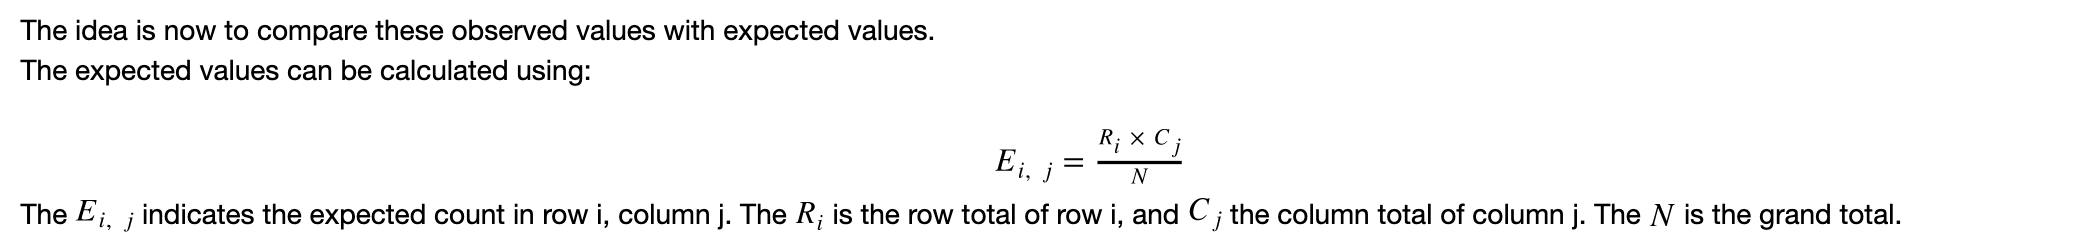

### Casualty type vs. Age of Casualty (CTvAOC)

In [ ]:
########### finding the expected output
expected_CTvAOC = np.zeros(observed_CTvAOC1.shape, dtype=int) 
colTotals_CTvAOC = observed_CTvAOC1.sum(axis = 0) 
rowTotals_CTvAOC = observed_CTvAOC1.sum(axis = 1)
N = rowTotals_CTvAOC.sum()

for i in range(observed_CTvAOC1.shape[0]):
    for j in range(observed_CTvAOC1.shape[1]):
        expected_CTvAOC[i,j] = (rowTotals_CTvAOC[i] * colTotals_CTvAOC[j]) / N
expected_CTvAOC


########## finding the chi value, p value, degrees of freedom and cramers v-value
statistics_values(observed_CTvAOC1)

###### Conclusion: There is a significant association between Casualty Type and Age of Casaulty as the P-value is less than 0.01. Moreover, the (Cramer) V value is not significantly close to 0, implying a weak association.

### Age of Driver vs. Accident Severity (AODvAS)

In [ ]:
########### Finding the expected output
expected_AODvAS = np.zeros(observed_AODvAS1.shape, dtype=int) 
colTotals_AODvAS = observed_AODvAS1.sum(axis = 0) 
rowTotals_AODvAS = observed_AODvAS1.sum(axis = 1)
N = rowTotals_AODvAS.sum()

for i in range(observed_AODvAS1.shape[0]):
    for j in range(observed_AODvAS1.shape[1]):
        expected_AODvAS[i,j] = (rowTotals_AODvAS[i] * colTotals_AODvAS[j]) / N
expected_AODvAS

########### Finding the chi value, p-value, and degrees of freedom, cramers value
statistics_values(observed_AODvAS1)

###### Conclusion: There is a significant association between the Age of the Driver and Accident Severity as proven by the P-value that is much less than 0.01, and the association is strong as the (Cramer) V value is closer to 0.

### Sex of Driver vs. Accident Severity (SODvAS)

In [ ]:
########### Finding the expected output
expected_SODvAS = np.zeros(observed_SODvAS1.shape, dtype=int) 
colTotals_SODvAS = observed_SODvAS1.sum(axis = 0) 
rowTotals_SODvAS = observed_SODvAS1.sum(axis = 1)
N = rowTotals_SODvAS.sum()

for i in range(observed_SODvAS1.shape[0]):
    for j in range(observed_SODvAS1.shape[1]):
        expected_SODvAS[i,j] = (rowTotals_SODvAS[i] * colTotals_SODvAS[j]) / N
expected_SODvAS

statistics_values(observed_SODvAS1)

###### Conclusion: With a P-value less than 0.01 there is a significant association between the Sex of the Driver and Accident severity. The association between Sex of Driver and Accident Severity is very strong as it is close to 0.

### Road surface conditions vs. Accident Severity (RSCvAS)

In [ ]:
########### Finding the expected output
expected_RSCvAS = np.zeros(observed_RSCvAS1.shape, dtype=int) 
colTotals_RSCvAS = observed_RSCvAS1.sum(axis = 0) 
rowTotals_RSCvAS = observed_RSCvAS1.sum(axis = 1)
N = rowTotals_RSCvAS.sum()

for i in range(observed_RSCvAS1.shape[0]):
    for j in range(observed_RSCvAS1.shape[1]):
        expected_RSCvAS[i,j] = (rowTotals_RSCvAS[i] * colTotals_RSCvAS[j]) / N
expected_AODvAS

########### Finding the chi value, p-value, and degrees of freedom, cramers value
statistics_values(observed_RSCvAS1)

###### Conclusion: There is NO significant association between Road Surface Conditions and Accident Severity, as the P-value is not less than 0.05 or 0.01.

### Time of Day vs. Accident Severity

In [ ]:
########### Finding the expected output
expected_TODvAS = np.zeros(observed_TODvAS1.shape, dtype=int) 
colTotals_TODvAS = observed_TODvAS1.sum(axis = 0) 
rowTotals_TODvAS = observed_TODvAS1.sum(axis = 1)
N = rowTotals_TODvAS.sum()

for i in range(observed_TODvAS1.shape[0]):
    for j in range(observed_TODvAS1.shape[1]):
        expected_TODvAS[i,j] = (rowTotals_TODvAS[i] * colTotals_TODvAS[j]) / N
expected_TODvAS

########### Finding the chi value, p-value, and degrees of freedom, cramers value
statistics_values(observed_TODvAS)

### Conclusion: There is NO Association between Time of Day and Accident Severity as the P-value (1.901) is not less than 0.01.

The following graphs show the observed vs. expected values in subplots for the following variables.
- Age of Driver vs. Accident Severity
- Sex of Driver vs. Accident Severity
- Road Surface conditions vs. Accident Severity
- Time of Day vs. Accident Severity

**Note: I did not include Casualty type vs. Age of Casualty as it is not as relevant as the other graphs... also couldn't make 5 graphs so I narrowed it down to 4 graphs instead of making 6 graphs.*

In [ ]:
fig, axes = plt.subplots(2,2)

#AODvAS: Age of Driver vs. Accident Severity

print(observed_AODvAS)
axes[0,0].plot(x, observed_AODvAS)
axes[0,0].plot(x, expected_AODvAS)
axes[0,0].set_title("Age of Driver compared to Accident Severity")

# SODvAS: Sex of Driver vs. Accident Severity
#axes[0,1].plot(observed_SODvAS, expected_SODvAS)
#axes[0,1].set_title("Sex of Driver compared to Accident Severity")

#RSCvAS: Road Surface Conditions vs. Accident Severity
#axes[1,0].plot(observed_RSCvAS, expected_RSCvAS)
#axes[0,0].set_title("Road Surface Conditions compared to Accident Severity")

#TODvAS: Time of Day vs. Accident Severity
#axes[1,1].plot(observed_TODvAS, expected_TODvAS)
#axes[1,1].set_title("Time of Day compared to Age of Casualty")

## Spatula Filtering and cleaning the data.


In [ ]:
cityname = "Birmingham"
cityid = "birmingham"
# the names of the column, and the name of the city (which are the same but casesensitive)

In [ ]:
lsoa = np.genfromtxt(PATH["data_external"] + "Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2.csv", delimiter=',', dtype=None, names=True, encoding='utf-8-sig')

In [ ]:
lsoa
#all LOSA polygon data into an LSOA 

In [ ]:
city_LSOA11CD_rows = np.flatnonzero(np.core.defchararray.find(lsoa['LSOA11NM'],cityname)!=-1)
city_LSOA11CD = lsoa['LSOA11CD'][city_LSOA11CD_rows]
city_LSOA11CD
#Just filtered all the LSOA data

In [ ]:
city_accidentindices = dataraw["accidents"]["Accident_Index"][np.isin(dataraw["accidents"]["LSOA_of_Accident_Location"], city_LSOA11CD)]
len(city_accidentindices)
#len of the Accident indexes that are also in the accident LSOA_Accident_location by the

In [ ]:
datacity = {}
for tablename in TABLENAMES:
    datacity[tablename] = dataraw[tablename][np.isin(dataraw[tablename]["Accident_Index"], city_accidentindices)]
#filtered out all the accident that by the accident index that we require

In [ ]:
for tablename in TABLENAMES:
    with open(PATH["data_interim"] + tablename + "_" + cityid + ".csv", "w") as f:
        w = csv.writer(f)
        w.writerow(dataraw[tablename].dtype.names)
        w.writerows(datacity[tablename])
#creates clean excel files in the PATH/data_interim location.

## Spatial Filtering with Shapely 

In [ ]:
with open(PATH["data_processed"] + "citieslad.json") as f:
    cities_json = json.load(f)
# Opened up a file and set the file to cities_jason variable

In [ ]:
cities_json[cityname]["geometry"]
#This shows all the coordanatates of the polygons of this file.

In [ ]:
city_boundary = shapely.geometry.shape(cities_json[cityname]["geometry"])
type(city_boundary)
print(city_boundary)
#Makes a shape out of those coordanates that is later overlaid on the map.

In [ ]:
city_boundary

In [ ]:
city_boundary.geom_type

In [ ]:
lon_list = dataraw["accidents"]["Longitude"]
lat_list = dataraw["accidents"]["Latitude"]

In [ ]:
city_acc_rowindices = []
for i in range(len(lon_list)):
    if Point(lon_list[i], lat_list[i]).within(city_boundary):
        city_acc_rowindices.append(i)
print(city_acc_rowindices)
#appends the latitude and longitude if they are in the city_boundary 

In [ ]:
with open(PATH["data_interim"] + "accidents_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["accidents"].dtype.names)
    w.writerows(datacity["accidents"])
#writes clean data of the cities (birminghams) accidents 

limit accidnets with casualties


In [ ]:
datacity["vehicles"] = dataraw["vehicles"][np.isin(dataraw["vehicles"]["Accident_Index"], datacity["accidents"]["Accident_Index"])]
datacity["casualties"] = dataraw["casualties"][np.isin(dataraw["casualties"]["Accident_Index"], datacity["accidents"]["Accident_Index"])]
#adds datacity in file if they are in the raw folder and if they are in the appropriate accident index.


In [ ]:
len(datacity["accidents"]), len(datacity["vehicles"]), len(datacity["casualties"])

In [ ]:
with open(PATH["data_interim"] + "vehicles_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["vehicles"].dtype.names)
    w.writerows(datacity["vehicles"])
#writes the clean birmingham vehicle data 

with open(PATH["data_interim"] + "casualties_" + cityid + "lad.csv", "w") as f:
    w = csv.writer(f)
    w.writerow(dataraw["casualties"].dtype.names)
    w.writerows(datacity["casualties"])
#writes the clean birmingham casualties datasets


## Making the map


In [ ]:
m = folium.Map(location=[52.486194, -1.890389],zoom_start=11, title ="Birmingham Casualties")
#initializes the map with the coordiant, zoom level and title
latlons = np.vstack((data_bir["accidents"]['Latitude'], data_bir["accidents"]['Longitude'])).T
#found the average of the latitude/longnitude (used for the heatmap below)
style = {'fillColor': '#e6fff7', 'color': '#228B22'}
folium.GeoJson(cities_json[cityname]["geometry"], name="Birmingham",style_function=lambda x:style).add_to(m)
#Set a green overlay of the birmingham are in green. To see where the city starts and ends. With a style and name.

_1214 = folium.FeatureGroup(name="12-14")
_0608 = folium.FeatureGroup(name="06-08")
_0810 = folium.FeatureGroup(name="08-10")
_1012 = folium.FeatureGroup(name="10-12")
_1416 = folium.FeatureGroup(name="14-16")
_1618 = folium.FeatureGroup(name="16-18")
_1820 = folium.FeatureGroup(name="18-20")
_2022 = folium.FeatureGroup(name="20-22")
rest = folium.FeatureGroup(name="20-06")
All_data = folium.FeatureGroup(name="All Data")

#Set a feature group for each of the timezones so that they could be filtered on the top right of the map.

#Below, i filtered out all of the appropriate data points a markers. Added popups to them and set them with a unique color.
for row in data_bir["accidents"]:
    All_data.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="deeppink",
                            fill = False
                            ))
    if row["Time"][:2] == "12" or row["Time"][:2] == "13":
        _1214.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkred",
                            fill = False
                            ))
    if row["Time"][:2] == "06" or row["Time"][:2] == "07":
        _0608.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                        radius = 4,
                        popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                        color="green",
                        fill = False
                        ))
    if row["Time"][:2] == "08" or row["Time"][:2] == "09":
        _0810.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="blue",
                            fill = False
                            ))
    if row["Time"][:2] == "10" or row["Time"][:2] == "11":
        _1012.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="gold",
                            fill = False
                            ))
    if row["Time"][:2] == "14" or row["Time"][:2] == "15":
        _1416.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="purple",
                            fill = False
                            ))
    if row["Time"][:2] == "16" or row["Time"][:2] == "17":
        _1618.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="indigo",
                            fill = False
                            ))
    if row["Time"][:2] == "18" or row["Time"][:2] == "19":
        _1820.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="brown",
                            fill = False
                            ))
    if row["Time"][:2] == "20" or row["Time"][:2] == "21":
        _2022.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkorange",
                            fill = False
                            ))
    else:
        rest.add_child(folium.Circle([row['Latitude'], row['Longitude']],
                radius = 4,
                popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                color="olive",
                fill = False
                ))
        
#added the featuregroups to the map 
m.add_child(All_data)
m.add_child(rest)
m.add_child(_2022)
m.add_child(_1214)   
m.add_child(_0608)
m.add_child(_0810)   
m.add_child(_1012)   
m.add_child(_1416)   
m.add_child(_1618)   
m.add_child(_1820)
# 
HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
#made a heatmap.
folium.LayerControl().add_to(m)
#used layercontrol to be able to use layers on the graph which allowed me to 
m

### map analysis (markers).
* data does not go outside green overlay 
* Most accidents are in the middle of the city. Specificall the main roads in the middle of the city. And they spread out a bit more to the south of birmingham then the wes. And east side gets less accidents (although the center of birmigham is closer to the west so that would happe.
* from 08-10 there are no accidents in northfolk but they are a bit lower donw in the birmingham are (may try to drive out of the city).
* form 10-12 there are very few accident in sutton coldifield (especially non in the center of sutton).

In [ ]:
latlons = np.vstack( (data_bir["accidents"]['Latitude'], data_bir["accidents"]['Longitude'])).T
#latitude and longnitude for the seconds g
centroid = list(MultiPoint(latlons).centroid.coords)[0]
#found the coordanates of the center
m2 = folium.Map(centroid, zoom_start=11, title="Clusters of Birmingham Accidents")
#Made a map
folium.GeoJson(cities_json[cityname]["geometry"], name="Birmingham",style_function=lambda x:style).add_to(m2)
#added a folium birmingham silhouette
#plotted a map with these centroids
marker_cluster1214 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 12-14').add_to(m2))
marker_cluster1416 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 14-16').add_to(m2))
marker_cluster1618 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 16-18').add_to(m2))
marker_cluster1820 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 18-20').add_to(m2))
marker_cluster2022 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 20-22').add_to(m2))
marker_cluster0608 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 06-08').add_to(m2))
marker_cluster0810 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 08-10').add_to(m2))
marker_cluster1012 = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 10-12').add_to(m2))
marker_cluster_rest = MarkerCluster().add_to(folium.FeatureGroup(name='Clusters 22 - 06').add_to(m2))
marker_cluster_all = MarkerCluster().add_to(folium.FeatureGroup(name="All data").add_to(m2))

#added cluster where each data is held and added to the map.These clusters will be on the map.

#below,i have filtered out the data for each cluster with neccesary information like color/accidnet index.
for row in datacity["accidents"]:
    folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="deeppink",
                            fill = False
                            ).add_to(marker_cluster_all)    
    if row["Time"][:2] == "12" or row["Time"][:2] == "13":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkred",
                            fill = False
                            ).add_to(marker_cluster1214)
    if row["Time"][:2] == "06" or row["Time"][:2] == "07":
        folium.Circle([row['Latitude'], row['Longitude']],
                        radius = 4,
                        popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                        color="green",
                        fill = False
                        ).add_to(marker_cluster0608)
    if row["Time"][:2] == "08" or row["Time"][:2] == "09":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="blue",
                            fill = False
                            ).add_to(marker_cluster0810)
    if row["Time"][:2] == "10" or row["Time"][:2] == "11":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="gold",
                            fill = False
                            ).add_to(marker_cluster1012)
    if row["Time"][:2] == "14" or row["Time"][:2] == "15":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="purple",
                            fill = False
                            ).add_to(marker_cluster1416)
    if row["Time"][:2] == "16" or row["Time"][:2] == "17":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="indigo",
                            fill = False
                            ).add_to(marker_cluster1618)
    if row["Time"][:2] == "18" or row["Time"][:2] == "19":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="brown",
                            fill = False
                            ).add_to(marker_cluster1820)
    if row["Time"][:2] == "20" or row["Time"][:2] == "21":
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkorange",
                            fill = False
                            ).add_to(marker_cluster2022)
    else:
        folium.Circle([row['Latitude'], row['Longitude']],
                radius = 3,
                popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                color="olvie",
                fill = False
                ).add_to(marker_cluster_rest)

HeatMap(latlons).add_to(folium.FeatureGroup(name='Heat Map for total').add_to(m2))
#added a heatmap 
folium.LayerControl().add_to(m2)
#added layers so that i could switch the specific clustered data on/off
m2

In [ ]:
m3 = folium.Map(centroid, zoom_start=11, titles = "Cluster of accident severity", title="Severity of Accidents")
#plotted a map with these centroids
folium.GeoJson(cities_json[cityname]["geometry"], name="Birmingham",style_function=lambda x:style).add_to(m3)
#added a folium birmingham silhouette

#Agian making clusters of data points.
marker_clusterSev1 = MarkerCluster().add_to(folium.FeatureGroup(name='Fatal:1 ').add_to(m3))
marker_clusterSev2 = MarkerCluster().add_to(folium.FeatureGroup(name='Serious:2').add_to(m3))
marker_clusterSev3 = MarkerCluster().add_to(folium.FeatureGroup(name='Slight:3').add_to(m3))
#datacity["vehicles"] = dataraw["vehicles"][np.isin(dataraw["vehicles"]["Accident_Index"], datacity["accidents"]["Accident_Index"])]
filtered_bir = data_bir["accidents"][np.isin(data_bir["accidents"]["Accident_Index"], data_bir["casualties"]["Accident_Index"])]
#a = pd.DataFrame(data=filtered_bir)

for row in filtered_bir:
    if row["Accident_Severity"] == 1:
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="goldenrod",
                            fill = False
                            ).add_to(marker_clusterSev1)
    if row["Accident_Severity"] == 2:
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkblue",
                            fill = False
                            ).add_to(marker_clusterSev2)
    if row["Accident_Severity"] == 3:
        folium.Circle([row['Latitude'], row['Longitude']],
                            radius = 4,
                            popup = row['Accident_Index'] + "\n" + row["Date"] + ", " + row["Time"],
                            color="darkred",
                            fill = False
                            ).add_to(marker_clusterSev3)
    
folium.LayerControl().add_to(m3)
#added layers so that i could switch the specific clustered data on/off
m3


### My analysis.
#### cluster map 
* there are no dots outisde of birmingham green sptcial are  (well cleaned).
* most of the accidents happen around the center of the city. (This is for All data)
    *the total cluster shows that there are 2623 accidents 
    *two of the clusters (1055,423) make up ~56.3 % of the accidents (all though more custer would be considered in the city center.
    *there are a few singled out clusters outside the border. Showing that accidents happen less in those areas (otherwise the numbers would be bigger or they would merge with a nearby cluster. 
* from 20-22 there seems to be way less accidents. Although teh lower part of birmigham (northfield) has 14  accident whereas the one cluster closer to the city center has 7. 
* betrween 06-08 (stechfor) cluster has low accident ,however, it is merged with a cluster that has high accidents or it itself has high accidents.
* form 10-12 in coldfield there are no clusters, so no accidents which is unusual.


# Investigating time vs accident severity in birmingham and the UK

The following code graphs the frequency of accidents filtered by gender, location, and accident severity. It also graphs the average accident severity for these variables where 1 is the highest severity and 3 is the lowest, this gives insights into which times have the most severe accidents. In total there are 30 possible combinations of variables that can make 30 different graphs of varying usefullness. The graphs of particular interest are discussed in further detain below the code.
<br>
Notes on the default scale:<br>
- The scale will stay the same when switching between graphs if default is not chosen<br>                                                      
- The scale will default if average severity is chosen as this graph uses a unique scale.


In [ ]:
def create_masked(Data,Severity,DriverGender):
    value_map={"Slight":3,"Serious":2,"Fatal":1}

    #Fliter dataset by gender if asked for
    if DriverGender =="Female":
        females_mask_vehicles = np.where(Data["vehicles"]["Sex_of_Driver"] == 2)
        vehicles_masked=Data["vehicles"][females_mask_vehicles]
        accident_id=vehicles_masked["Accident_Index"]
        accidents_masked = np.where(np.isin(Data["accidents"]["Accident_Index"], (accident_id)))
        Data=Data["accidents"][accidents_masked]
    elif DriverGender =="Male":
        males_in_vehicles = np.where(Data["vehicles"]["Sex_of_Driver"] == 1)
        vehicles_masked=Data["vehicles"][males_in_vehicles]
        accident_id=vehicles_masked["Accident_Index"]
        accidents_masked = np.where(np.isin(Data["accidents"]["Accident_Index"], (accident_id)))
        Data=Data["accidents"][accidents_masked]
    else:
        Data=Data["accidents"]
    
    #Filter by severity
    if Severity=="All":
        return Data
    elif Severity=="Average":
        average_dict={}
        #Create dict for all and find av.
        mask=np.where(Data["Accident_Severity"]==value_map["Fatal"])
        Fatal=Data[mask]
        dict_of_fatal=create_dict(Fatal)
        mask=np.where(Data["Accident_Severity"]==value_map["Serious"])
        Serious=Data[mask]
        dict_of_serious=create_dict(Serious)
        mask=np.where(Data["Accident_Severity"]==value_map["Slight"])
        Slight=Data[mask]
        dict_of_slight=create_dict(Slight)
        #finding average
        for key in dict_of_fatal:
            total=dict_of_fatal[key]+dict_of_serious[key]+dict_of_slight[key]
            average_dict[key]=((dict_of_fatal[key]+2*dict_of_serious[key]+3*dict_of_slight[key])/total)
        return average_dict
    else:
        mask=np.where(Data["Accident_Severity"]==value_map[Severity])
        Data=Data[mask]
        return Data
  

In [ ]:
def create_dict(Data):
##create a dictionart with the keys as time bins and the values as frequencies
    times_dic_count = {"":0}
    for time_category in time_categories:
        times_dic_count[time_category] = 0
    
    for i in range(len(Data["Time"])):
        times_dic_count[Data["Time"][i][:2]] += 1
    del times_dic_count[""]        
    return times_dic_count

In [ ]:
def title_labels(Severity,Region,DriverGender):
    #creates labels and titles depending on the graph type
    xlabel="Time of Day"
    if DriverGender=="Don't Show Gender":
        DriverGender=""
    if Severity=="Average":
        title=(f"Average Severity of {DriverGender} Drivers in {Region} by Time of Day")
        ylabel="Average Severity of Accidents 1-3 where 1 is Fatal, 2 is Serious, and 3 is Slight"
    else:
        title=(f"Frequency of Accidents of {Severity} Severity by {DriverGender} Drivers in {Region} by Time of Day")
        ylabel="Frequency"
    return title,xlabel,ylabel

In [ ]:
def create_plot(Data,Severity,title,xlabel,ylabel,scale,default,DriverGender):
    #plots the different graphs
    colour_dict={"Fatal":"indianred","Serious":"sandybrown","Slight":"wheat"}
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if Severity=="All":
        #plot slight
        Severity="Slight"
        temp_data=create_masked(Data,Severity,DriverGender)
        dictionary=create_dict(temp_data)
        plt.bar(dictionary.keys(),dictionary.values(),label=Severity,color=colour_dict[Severity])
        Severity="Serious"
        temp_data=create_masked(Data,Severity,DriverGender)
        dictionary=create_dict(temp_data)
        plt.bar(dictionary.keys(),dictionary.values(),label=Severity,color=colour_dict[Severity])
        Severity="Fatal"
        temp_data=create_masked(Data,Severity,DriverGender)
        dictionary=create_dict(temp_data)
        plt.bar(dictionary.keys(),dictionary.values(),label=Severity,color=colour_dict[Severity])
        plt.legend(title="Severity of Accident")
    elif Severity=="Average":
        plt.plot(Data.keys(),Data.values())
        plt.ymin=1.5
        plt.ymax=1
        plt.gca().invert_yaxis()
    else:
        dictionary=create_dict(Data)
        if default==0:
            plt.ylim(0,5**scale)
        plt.bar(dictionary.keys(),dictionary.values(),label=Severity,color=colour_dict[Severity])
    pass

In [ ]:
def f(Severity,Region,DriverGender,scale,default):
    #takes the interactive inputs and creates a graph of the users choosing.
    
    #We want the default scale for the average severity graph
    if Severity=="Average":
        default=True
        
    #Starting data set by region
    if Region=="Birmingham":
        Data=data_bir
    else:
        Data=dataraw
        
    #Select mask using function above
    if Severity!="All":
        Data=create_masked(Data,Severity,DriverGender)

    #find labels using function above
    title,xlabel,ylabel=title_labels(Severity,Region,DriverGender)
    
    #plot using function above
    create_plot(Data,Severity,title,xlabel,ylabel,scale,default,DriverGender)
        
        
        
#This code creates the interactive elements of the graph and is the input of the function f()        
interactive(f,Severity=["Slight","Serious","Fatal","All","Average"],
            Region=["England","Birmingham"],
            DriverGender=["Don't Show Gender","Male","Female"],
            scale=FloatSlider(min=1,max=6,step=0.25,value=5,description="Scale 5^x "),
            default=Checkbox(True,description="Enable Default Scale")
           )

# Graphs of interest from the interactive graph:
- **all england**<br>
good overview of frequency of each type by hour, big rushhour increase in accidents

- **all birmingham**<br>
good overview of frequency of each type by hour, big rushhour increase in accidents
- **average england**<br>
most severe accidents happen in the early hours and late at night, whereas the rushhour accidents seem to be less fatal or severe. This can also be seen to somme extent in the birmingham graph but there isnt enoug data for the 24 bins to make much sense due to less data so graph doesnt show as nice a relashionship.
- **all female vs all male for both birmingham and england**<br>
if you keep the scale the same then you can see the large difference in the number of accidents women are in vs men. This may be because there are more male drivers or that women drive more safely.
- **fatal male vs female for both england and birmingham**<br>
way way less fatal accidents with female drivers and there was only one fatal female accident in birmingham. Not many fatal accidents in birmingham so not much data for severe graph
- **average england male vs female**<br>
females have less average accident severity. The data for the same graphs for birmingham doesnt show much


